In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import SGD
from keras.optimizers import Adam
import numpy as np
from sklearn.datasets import fetch_lfw_pairs
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import optuna
from optuna import Trial
import plotly



e:\projects\encoder\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

lfw_pairs_train = fetch_lfw_pairs(subset='train',color=True)
pairs = lfw_pairs_train.pairs   
labels = lfw_pairs_train.target

augmented_pairs = []
augmented_labels = []

for i in range(len(pairs)):
    img1, img2 = pairs[i]
    label = labels[i]
    aug_img1 = data_augmentation(img1)
    aug_img2 = data_augmentation(img2)
    augmented_pairs.append([aug_img1.numpy(), aug_img2.numpy()])
    augmented_labels.append(label)

pairs_expanded = np.concatenate([pairs, np.array(augmented_pairs)], axis=0)
labels_expanded = np.concatenate([labels, np.array(augmented_labels)], axis=0)

pairs_train, pairs_test, labels_train, labels_test = train_test_split(
    pairs_expanded, labels_expanded, test_size=0.2, random_state=42, shuffle=True
)
pairs_train_full = pairs_train
labels_train_full = labels_train
pairs_train, pairs_val, labels_train, labels_val = train_test_split(
    pairs_train_full, labels_train_full, test_size=0.25, random_state=42, shuffle=True
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)


Generation pairs of images from LFW dataset extended with augmented variants

In [3]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(
        y_true * tf.square(y_pred) + 
        (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))
    )
def residual_block(x, filters, kernel_size=3, stride=1):
    
    shortcut = x
        
    x = layers.Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
        
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
        
    
    if shortcut.shape[-1] != filters or stride > 1:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
        
    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)

def encoder(input_shape, latent_dim,dropout_rate, l1, l2):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)  
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)  
    x = residual_block(x, 256)
    conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(x)
    conv7 = layers.Conv2D(64, (7, 7), padding='same', activation='relu')(x)
    merged = layers.concatenate([conv3, conv5, conv7])
    attention = layers.Conv2D(192, (1,1), activation='sigmoid')(merged)
    weighted = layers.Multiply()([merged, attention])
    x = layers.GlobalAveragePooling2D()(weighted)
    x = layers.Dropout(dropout_rate)(x)
    latent = layers.Dense(
        latent_dim, 
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2),
        name='latent'
    )(x)
    return keras.Model(inputs, latent, name='encoder')

Encoder and ReSu cores for encoding images and downsample them

In [ ]:
def objective(trial: Trial):
   
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.7)
    latent_dim = trial.suggest_int('latent_dim', 32, 256)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    l1 = trial.suggest_float('l1', 1e-6, 1e-3, log=True)
    l2 = trial.suggest_float('l2', 1e-6, 1e-3, log=True)
    encode = encoder(input_shape, latent_dim, dropout_rate, l1, l2)
    input_a=keras.Input(shape=input_shape)
    input_b=keras.Input(shape=input_shape)

    embedding_a = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(encode(input_a))
    embedding_b = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(encode(input_b))
    distance = layers.Lambda(lambda emb: tf.norm(emb[0] - emb[1], axis=1, keepdims=True))(
    [embedding_a, embedding_b]
    )   
    siamese_model = keras.Model(inputs=[input_a, input_b], outputs=distance)
    siamese_model.compile(optimizer=Adam(learning_rate=lr), loss=contrastive_loss, metrics=[])

    siamese_model.fit(
        [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
        batch_size=16,
        epochs=30,
        validation_data=([pairs_val[:, 0], pairs_val[:, 1]], labels_val),  
        callbacks=[early_stopping],
        verbose=0
    )
    distances_val = siamese_model.predict([pairs_val[:, 0], pairs_val[:, 1]], verbose=0)
    auc = roc_auc_score(labels_val, -distances_val)
    return auc

input_shape = (62, 47, 3)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=8,show_progress_bar=True)
optuna.visualization.plot_optimization_history(study).show()
best_params = study.best_params
print(f"Best params: {best_params}")

[I 2025-06-24 21:04:36,318] A new study created in memory with name: no-name-e93bd21a-ce48-4bd7-bae9-4d5bf3bdf6be
  0%|          | 0/3 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.630641:  33%|███▎      | 1/3 [04:23<08:46, 263.21s/it]

[I 2025-06-24 21:08:59,529] Trial 0 finished with value: 0.630640826873385 and parameters: {'dropout_rate': 0.4682553224202305, 'latent_dim': 161, 'lr': 0.00010380280230171728, 'l1': 5.391051866142528e-05, 'l2': 5.474893904998746e-05}. Best is trial 0 with value: 0.630640826873385.


Best trial: 1. Best value: 0.682693:  67%|██████▋   | 2/3 [10:15<05:15, 315.45s/it]

[I 2025-06-24 21:14:51,554] Trial 1 finished with value: 0.6826925064599484 and parameters: {'dropout_rate': 0.48592784397981764, 'latent_dim': 89, 'lr': 0.00019736744105363876, 'l1': 1.079963386024247e-05, 'l2': 0.00011178001985470545}. Best is trial 1 with value: 0.6826925064599484.


Best trial: 1. Best value: 0.682693: 100%|██████████| 3/3 [16:08<00:00, 322.68s/it]


[I 2025-06-24 21:20:44,370] Trial 2 finished with value: 0.6292609819121447 and parameters: {'dropout_rate': 0.2969384570458061, 'latent_dim': 57, 'lr': 1.1859248052640524e-05, 'l1': 4.1758718786296456e-05, 'l2': 0.00012298735465331376}. Best is trial 1 with value: 0.6826925064599484.


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [6]:
encode = encoder(
    input_shape, 
    best_params['latent_dim'], 
    best_params['dropout_rate'],
    best_params['l1'],
    best_params['l2']
)
input_a=keras.Input(shape=input_shape)
input_b=keras.Input(shape=input_shape)
embedding_a = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(encode(input_a))
embedding_b = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(encode(input_b))
distance = layers.Lambda(lambda emb: tf.norm(emb[0] - emb[1], axis=1, keepdims=True))(
    [embedding_a, embedding_b]
)
siamese_model = keras.Model(inputs=[input_a, input_b], outputs=distance)

siamese_model.compile(optimizer=Adam(learning_rate=best_params['lr']), loss=contrastive_loss, metrics=[])
history_new=siamese_model.fit(
    [pairs_test[:, 0], pairs_test[:, 1]], labels_test,
    batch_size=32,
    epochs=20,
    verbose=1
    
)

NameError: name 'best_params' is not defined

normalazing data and making contrastive loss func based on eucliud's distance

In [ ]:
distances_test = siamese_model.predict([pairs_test[:, 0], pairs_test[:, 1]])
auc = roc_auc_score(labels_test, -distances_test)
print(f"Final Test AUC: {auc:.4f}")


Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 199ms/step - loss: 0.3007 - val_loss: 0.5209 - learning_rate: 0.0010
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - loss: 0.2731 - val_loss: 0.5057 - learning_rate: 0.0010
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 210ms/step - loss: 0.2679 - val_loss: 0.5069 - learning_rate: 0.0010
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - loss: 0.2621 - val_loss: 0.4920 - learning_rate: 0.0010
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - loss: 0.2569 - val_loss: 0.3652 - learning_rate: 0.0010
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 210ms/step - loss: 0.2536 - val_loss: 0.3695 - learning_rate: 0.0010
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.2529
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 249ms/step - loss: 0.2529 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 214ms/step - loss: 0.2489 - val

training the model

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Test AUC: 0.6388


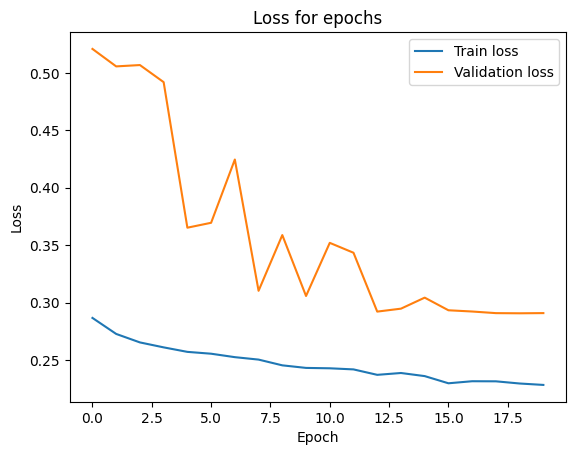

In [ ]:
plt.plot(history_new.history['loss'], label='Train loss')
plt.plot(history_new.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for epochs')
plt.legend()
plt.show()






loss for epochs graphs and ROC AUC stats

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


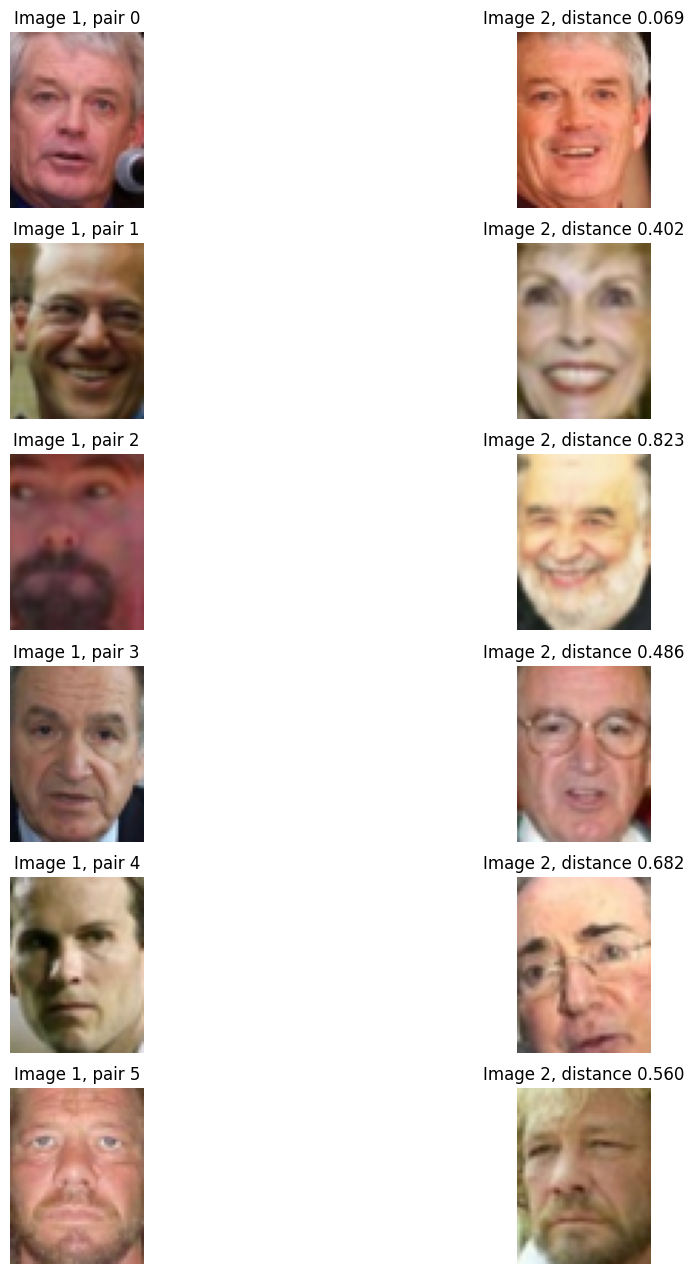

In [ ]:

plt.figure(figsize=(12, 16))
for im in range(10):  
    img1 = pairs_test[im][0]
    img2 = pairs_test[im][1]
    img1_batch = img1[np.newaxis, ...]
    img2_batch = img2[np.newaxis, ...]
    distance_val = siamese_model.predict([img1_batch, img2_batch])
    plt.subplot(6, 2, 2*im+1)
    plt.imshow(img1.squeeze(), cmap='gray')
    plt.title(f'Image 1, pair {im}')
    plt.axis('off')
    plt.subplot(6, 2, 2*im+2)
    plt.imshow(img2.squeeze(), cmap='gray')
    plt.title(f'Image 2, distance {distance_val[0][0]:.3f}')
    plt.axis('off')
plt.show()

example of working 